<a href="https://colab.research.google.com/github/lanzetti1/Univesp/blob/main/Aula_15_Pr%C3%A1tica_de_Segmenta%C3%A7%C3%A3o_Sem%C3%A2ntica_com_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COM530 - Visão Computacional

## Semana 5 - Segmentação
## Videoaula 15 - Prática de Segmentação Semântica com CNN

- Importando os pacotes e imagens
- Analisando as imagens
- Preparando os dados
- Construindo uma rede convolucional Unet
- Treinando a rede
- Avaliando os resultados

Observações: 
- Ativar a GPU (Menu [Runtime], opção [Change runtime type])
- Sem GPU, a execução deste caderno pode levar mais de 40 minutos.


#Importar os pacotes e carregar os dados.

O conjunto de dados utilizado nesta aula foi construído a partir de imagens de Microscopia Eletrônica, as quais estão disponíveis em: https://www.epfl.ch/labs/cvlab/data/data-em/

Essas imagens estão em alta-resolução e foram segmentadas em mitocôndrias e sinapses.

A partir dessas imagens, foram geradas "sub-imagens" 256x256 a partir das regiões das imagens originais. Essas imagens 256x256 são as utilizadas nesta aula.

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import normalize
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

#Carregando as imagens

O conjunto de dados utilizado nesta aula foi construído a partir de imagens de Microscopia Eletrônica, as quais estão disponíveis em: https://www.epfl.ch/labs/cvlab/data/data-em/

Essas imagens estão em alta-resolução e foram segmentadas em mitocôndrias e sinapses.

A partir dessas imagens, foram geradas "sub-imagens" 256x256 a partir das regiões das imagens originais. Essas imagens 256x256 são as utilizadas nesta aula.

In [ ]:
!wget https://www.dropbox.com/s/rntsian2o49lzc5/256.zip?dl=1 -O 256.zip
!mkdir -p tmp/mitochondria/

local_zip = '256.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/mitochondria/')
zip_ref.close()

--2023-04-26 21:09:21--  https://www.dropbox.com/s/rntsian2o49lzc5/256.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rntsian2o49lzc5/256.zip [following]
--2023-04-26 21:09:22--  https://www.dropbox.com/s/dl/rntsian2o49lzc5/256.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucad063691117428bbcc28d903e3.dl.dropboxusercontent.com/cd/0/get/B67Eh5t8ZKv4hjDxElJkErGC6xz0fviiXxqSnkNv63pu52cJQcJKy6IjTeFO_Ygw8W_9LCq853DfK1oze6N8NTd9AELb03GkBBccRd_7VA2iw11I198nM4YOxp1_bW_QOgCeXUHzq7xMHCeayfMgMx33YWUIXqp9JNc2qDj4T4UMYg/file?dl=1# [following]
--2023-04-26 21:09:23--  https://ucad063691117428bbcc28d903e3.dl.dropboxusercontent.com/cd/0/get/B67Eh5t8ZKv4hjDxElJkErGC6xz0fviiXxqSnkNv63pu52cJQcJKy6IjTeFO_Ygw8W_9LCq853DfK1oze6N8NTd9AE

Especificar os diretórios das imagens e respectivas máscaras.

In [ ]:
image_directory = 'tmp/mitochondria/256/images/'
mask_directory = 'tmp/mitochondria/256/masks/'

In [ ]:
SIZE = 256
num_images = 500

Lendo as imagens.

In [ ]:
image_names = glob.glob("tmp/mitochondria/256/images/*.tif")
print(image_names)

['tmp/mitochondria/256/images/image_84_13.tif', 'tmp/mitochondria/256/images/image_17_03.tif', 'tmp/mitochondria/256/images/image_68_01.tif', 'tmp/mitochondria/256/images/image_161_21.tif', 'tmp/mitochondria/256/images/image_77_21.tif', 'tmp/mitochondria/256/images/image_52_01.tif', 'tmp/mitochondria/256/images/image_86_03.tif', 'tmp/mitochondria/256/images/image_128_13.tif', 'tmp/mitochondria/256/images/image_4_12.tif', 'tmp/mitochondria/256/images/image_0_00.tif', 'tmp/mitochondria/256/images/image_32_13.tif', 'tmp/mitochondria/256/images/image_105_21.tif', 'tmp/mitochondria/256/images/image_104_10.tif', 'tmp/mitochondria/256/images/image_115_02.tif', 'tmp/mitochondria/256/images/image_138_02.tif', 'tmp/mitochondria/256/images/image_22_00.tif', 'tmp/mitochondria/256/images/image_82_02.tif', 'tmp/mitochondria/256/images/image_107_01.tif', 'tmp/mitochondria/256/images/image_31_01.tif', 'tmp/mitochondria/256/images/image_100_13.tif', 'tmp/mitochondria/256/images/image_2_01.tif', 'tmp/mi

In [ ]:
image_names.sort()
print(image_names)
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

['tmp/mitochondria/256/images/image_0_00.tif', 'tmp/mitochondria/256/images/image_0_01.tif', 'tmp/mitochondria/256/images/image_0_02.tif', 'tmp/mitochondria/256/images/image_0_03.tif', 'tmp/mitochondria/256/images/image_0_10.tif', 'tmp/mitochondria/256/images/image_0_11.tif', 'tmp/mitochondria/256/images/image_0_12.tif', 'tmp/mitochondria/256/images/image_0_13.tif', 'tmp/mitochondria/256/images/image_0_20.tif', 'tmp/mitochondria/256/images/image_0_21.tif', 'tmp/mitochondria/256/images/image_0_22.tif', 'tmp/mitochondria/256/images/image_0_23.tif', 'tmp/mitochondria/256/images/image_100_00.tif', 'tmp/mitochondria/256/images/image_100_01.tif', 'tmp/mitochondria/256/images/image_100_02.tif', 'tmp/mitochondria/256/images/image_100_03.tif', 'tmp/mitochondria/256/images/image_100_10.tif', 'tmp/mitochondria/256/images/image_100_11.tif', 'tmp/mitochondria/256/images/image_100_12.tif', 'tmp/mitochondria/256/images/image_100_13.tif', 'tmp/mitochondria/256/images/image_100_20.tif', 'tmp/mitochondr

Em seguida, ler as máscaras da mesma forma.

In [ ]:
mask_names = glob.glob(mask_directory + "*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

Algumas informações sobre as imagens.

In [ ]:
print("Dimensões da imagem são: ", image_dataset.shape)
print("Dimensões das máscaras são: ", mask_dataset.shape)
print("Pixel máximo na imagem é: ", image_dataset.max())
print("Rótulos na imagem são: ", np.unique(mask_dataset))

Dimensões da imagem são:  (500, 256, 256, 1)
Dimensões das máscaras são:  (500, 256, 256, 1)
Pixel máximo na imagem é:  225
Rótulos na imagem são:  [  0 255]


# Preparando os dados

Normalizando as imagens para o intervalo [0-,1].

In [ ]:
# Normalizar as imagens
image_dataset = image_dataset /255.  # Também é possível normalizar ou escalar usando MinMax.
# Não normalizar as máscaras, apenas reescolar para valores entre 0 e 1.
mask_dataset = mask_dataset /255.  # Cada pixel terá valor entre 0 e 1.

Separando o conjunto de imagens em treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


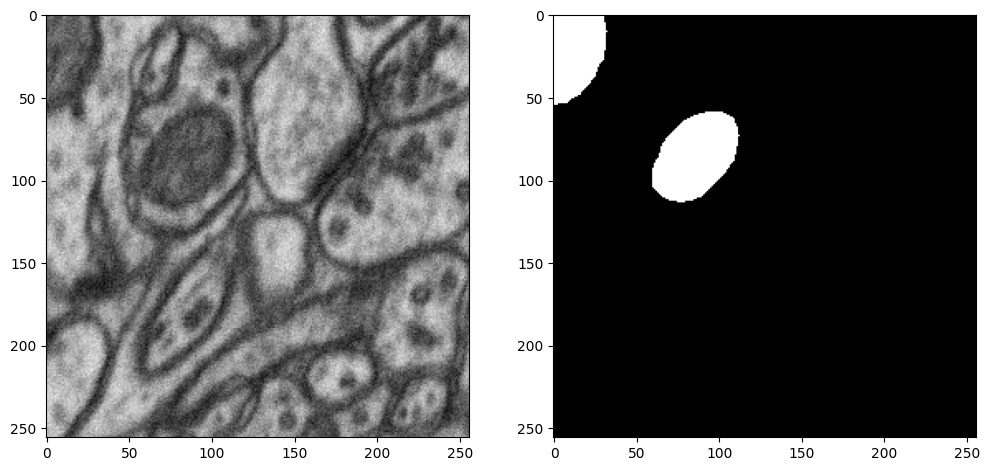

In [ ]:
# Visualizar uma imagem aleatória e sua respectiva máscara.
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

#Construindo uma rede convolucional Unet

In [ ]:
# Gerar uma Unet dividindo o encoder do decoder em blocos

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   # Não tem na rede original 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  # Não tem na rede original
    x = Activation("relu")(x)

    return x

# bloco Encoder: bloco Convolutional seguido por um Max pooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# bloco Decoder
#  skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Construir uma rede Unet usando os blocos
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binária
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

Visualização gráfica do modelo (rede Unet).

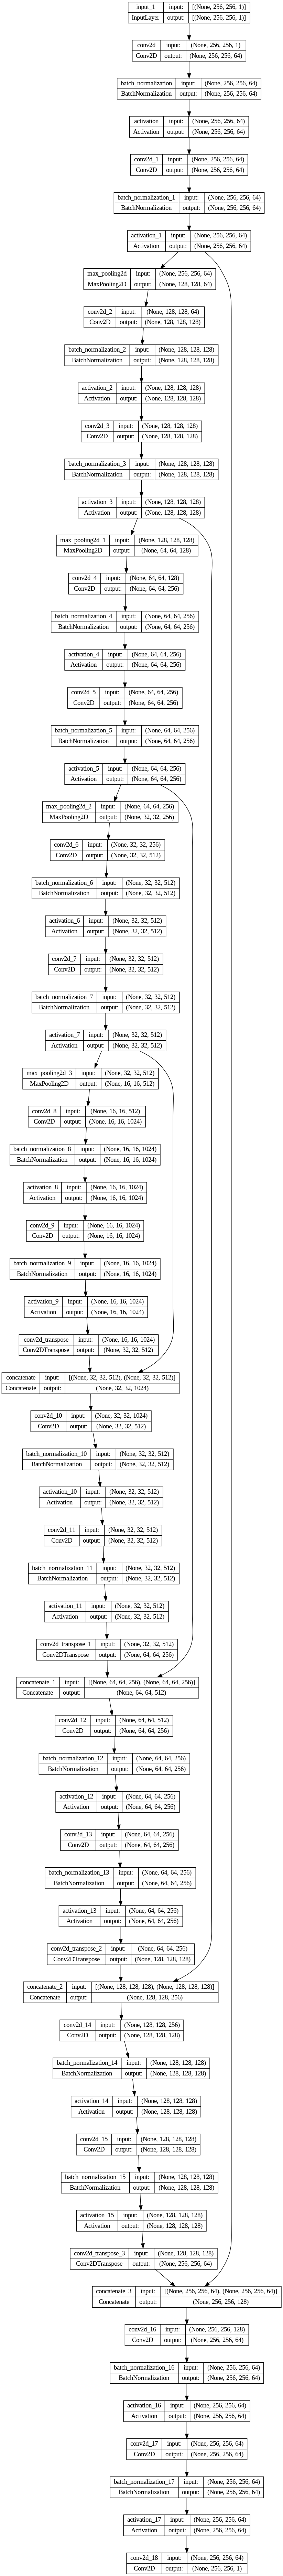

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

#Treinando a rede

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=25, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


Epoch 1/25
25/25 [==============================] - 56s 1s/step - loss: 0.3345 - accuracy: 0.8880 - val_loss: 15.4812 - val_accuracy: 0.3058
Epoch 2/25
25/25 [==============================] - 21s 845ms/step - loss: 0.1300 - accuracy: 0.9687 - val_loss: 74.0075 - val_accuracy: 0.0450
Epoch 3/25
25/25 [==============================] - 22s 896ms/step - loss: 0.0955 - accuracy: 0.9759 - val_loss: 23.0022 - val_accuracy: 0.0452
Epoch 4/25
25/25 [==============================] - 22s 901ms/step - loss: 0.0707 - accuracy: 0.9838 - val_loss: 1.2016 - val_accuracy: 0.4320
Epoch 5/25
25/25 [==============================] - 23s 906ms/step - loss: 0.0536 - accuracy: 0.9890 - val_loss: 0.2026 - val_accuracy: 0.9493
Epoch 6/25
25/25 [==============================] - 23s 914ms/step - loss: 0.0439 - accuracy: 0.9907 - val_loss: 0.3381 - val_accuracy: 0.9175
Epoch 7/25
25/25 [==============================] - 23s 917ms/step - loss: 0.0357 - accuracy: 0.9927 - val_loss: 0.2557 - val_accuracy: 0.9278

Salvando a rede.

In [ ]:
# Salva o modelo resultante (treinado) para podermos usá-lo posteriormente
model.save('tmp/mitochondria/saved_models/tutorial118_mitochondria_25epochs.hdf5')


#Avaliando os resultados

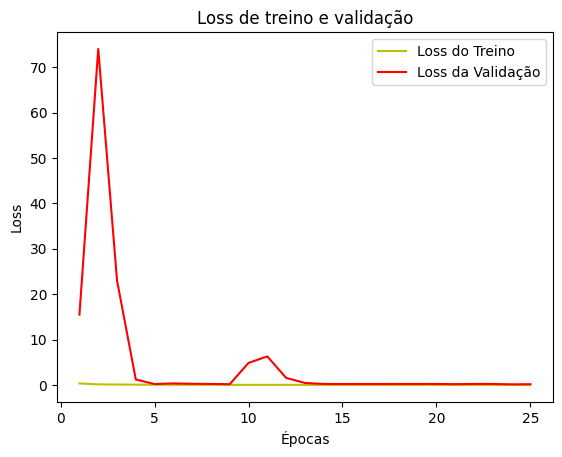

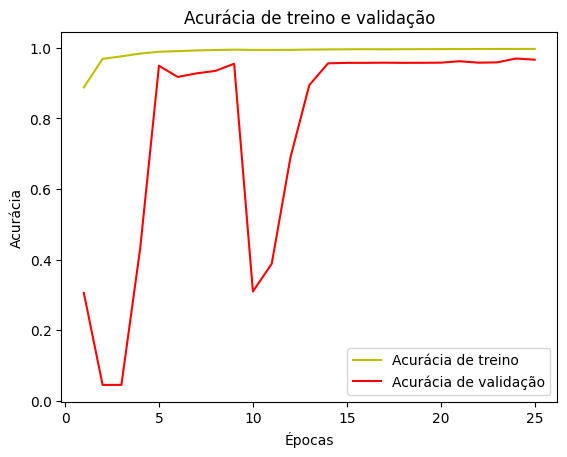

In [ ]:
# "plotar" a acurácia e loss de treino e validação em cada época
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Loss do Treino')
plt.plot(epochs, val_loss, 'r', label='Loss da Validação')
plt.title('Loss de treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Acurácia de treino')
plt.plot(epochs, val_acc, 'r', label='Acurácia de validação')
plt.title('Acurácia de treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [ ]:
# Carregar o modelo previamente gravado
from keras.models import load_model
model = load_model("tmp/mitochondria/saved_models/tutorial118_mitochondria_25epochs.hdf5", compile=False)
        

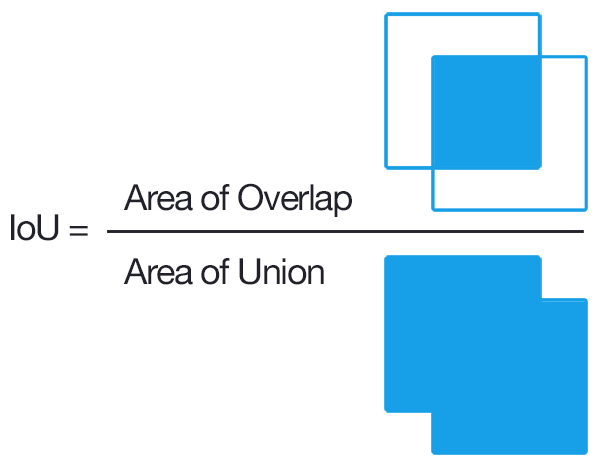

In [ ]:
# IoU (Intersection over Union)
threshold = 0.5
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > threshold

4/4 [==============================] - 17s 347ms/step


Média IoU = 0.60346085
(1, 256, 256, 1)
1/1 [==============================] - 0s 20ms/step
(256, 256)


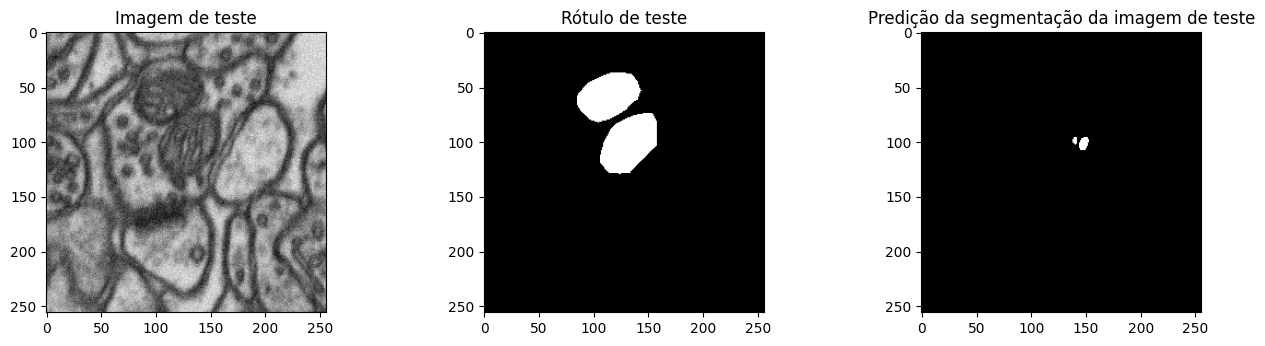

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Média IoU =", IOU_keras.result().numpy())

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Imagem de teste')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Rótulo de teste')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Predição da segmentação da imagem de teste')
plt.imshow(prediction, cmap='gray')

plt.show()

#Agradecimento:

Aula prática baseada no material disponibilizado em:
https://youtu.be/oBIkr7CAE6g
